## Importations

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sql
import configparser
import datetime
import seaborn as sns
import matplotlib.pyplot as plt 
import io
import boto3
import json
from botocore.config import Config
from sklearn.cluster import KMeans

## Configuration

In [2]:
config = configparser.ConfigParser()
config.read('../config/default.ini')

['../config/default.ini']

In [3]:
engine = sql.create_engine('postgresql://{}:{}@{}:{}/{}'.format(config['DATABASE']['username'], config['DATABASE']['password'].replace('_percentage_', '%'), config['DATABASE']['host'], config['DATABASE']['port'], config['DATABASE']['database']),pool_recycle=600)

In [4]:
try:
    ssm = boto3.client('ssm')
    s3 = boto3.client('s3')
    s3_resource = boto3.resource('s3')
except:
    aws_config = Config(region_name=config['DEFAULT']['AWS_DEFAULT_REGION'])    

    aws_session = boto3.session.Session(
        aws_access_key_id=config['DEFAULT']['AWS_ACCESS_KEY_ID'],
        aws_secret_access_key=config['DEFAULT']['AWS_SECRET_ACCESS_KEY']            
    )

    ssm = aws_session.client('ssm', config=aws_config)
    s3 = aws_session.client('s3', config=aws_config)
    s3_resource = aws_session.resource('s3')  

## Utilitaires

In [5]:
def export_df(df, name, date=True):
    df.to_csv('../output/{}{}.csv'.format('{}_'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d')) if date else '', name), index=False, encoding='utf-8-sig')

In [6]:
def export_fig(plot, name, date=True):
    plot.savefig('../images/{}{}.png'.format('{}_'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d')) if date else '', name))

In [7]:
len_labels = [
    'very_short',
    'short',
    'medium',
    'long',
    'very_long'
]

In [56]:
tod_list = ['night','morning','noon','afternoon','evening']

In [8]:
def assign_length_label(chars):
    if chars < 1000:
        return 0
    elif chars < 1500:
        return 1
    elif chars < 2000:
        return 2
    elif chars < 3000:
        return 3
    else:
        return 4

In [9]:
def assign_segment(num_segments,value):
    seg = 0
    i = 0
    seglen = 1.0/(num_segments*1.0)
    while i <= 1:
        if value <= i:
            return seg
        seg += seg+1
        i = seg*seglen

In [50]:
def choose_best(tod_list, row):
    best = 0
    best_label = ''
    for tod in tod_list:
        if row[tod] > best:
            best = row[tod]
            best_label = tod
    return best_label

## Données

In [10]:
df_art = pd.read_sql_query("""select cast(id as varchar), charcounter from article_article where published = '1' and displaydate <= current_date and charcounter > 0""", engine)
df_art.count()

id             101421
charcounter    101421
dtype: int64

array([[<AxesSubplot:title={'center':'charcounter'}>]], dtype=object)

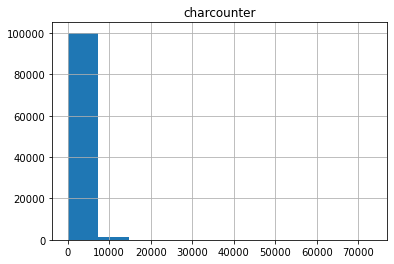

In [11]:
df_art[['charcounter']].hist(bins=10)

In [54]:
df_art['length'] = df_art['charcounter'].apply(assign_length_label)
df_art['art_length'] = df_art['length'].apply(lambda x: len_labels[x])
df_art.head(50)

id  charcounter  length  art_length
0   5233533         1913       2      medium
1   7197373          945       0  very_short
2   7755551         2400       3        long
3   7735335          647       0  very_short
4   7788265          875       0  very_short
5   8028880          867       0  very_short
6   8011179         1626       2      medium
7   7979198         1052       1       short
8   8005934         3736       4   very_long
9   8138902         2242       3        long
10  8159392         1484       1       short
11  8326291         3015       4   very_long
12  8473698         1156       1       short
13  8516554         1829       2      medium
14  8407775         1057       1       short
15  8600916         1714       2      medium
16  8516686         1024       1       short
17  8401843         3847       4   very_long
18  8920182         1642       2      medium
19  8457921         1321       1       short
20  8473790          859       0  very_short
21  8957807          777       0  very_short
22  8523278         2175       3        long
23  8999796         1543       2      medium
24  9015203         1990       2      medium
25  8904358         1578       2      medium
26  8923716          407       0  very_short
27  9013463         1350       1       short
28  8948420          637       0  very_short
29  8957809          683       0  very_short
30  8945395          978       0  very_short
31  8949412          319       0  very_short
32  9031086         1107       1       short
33  8999798         1853       2      medium
34  8994550          431       0  very_short
35  9020911          931       0  very_short
36  9065567         1087       1       short
37  9011857         1250       1       short
38  9138313         1594       2      medium
39  9154867          428       0  very_short
40  9090105         1881       2      medium
41  9109271          664       0  very_short
42  9166353         1741       2      medium
43  9134801         2273       3        long
44  9057871          551       0  very_short
45  9248719          255       0  very_short
46  9250366         2828       3        long
47  9290120         1304       1       short
48  9246979          545       0  very_short
49  9303474         1182       1       short

array([[<AxesSubplot:title={'center':'length'}>]], dtype=object)

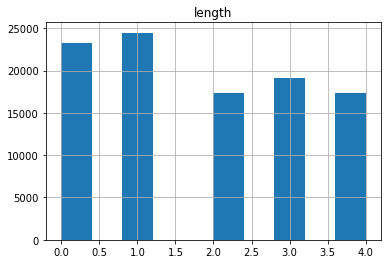

In [13]:
df_art[['length']].hist(bins=10)

In [43]:
df_vshort = pd.read_sql_query("""
    SELECT 
        uid, 
        COUNT(DISTINCT egos.id) AS conso
    FROM egos_article_conso_metrics_2021 egos INNER JOIN article_article art
        ON egos.id = art.id
    WHERE charcounter < 1000  
    GROUP BY uid
""", engine)
df_vshort.head()

uid  conso
0                   0307954547154dfe8d6173bdb05d1b7b    646
1                   0f40e6a7be3b4a7c89bc3a33d27776c7     19
2                   bf811daef52e442490ca66a754f96fc8   4895
3  _guid_JCNumevrf1-jfqsYdXnslkK5K7h5DBaQVRGDFQgk...     63
4                   219566cb14d142dda88ecf6643d0618c    938

In [44]:
df_short = pd.read_sql_query("""
    SELECT 
        uid, 
        COUNT(DISTINCT egos.id) AS conso
    FROM egos_article_conso_metrics_2021 egos INNER JOIN article_article art
        ON egos.id = art.id
    WHERE charcounter < 1500  
    GROUP BY uid
""", engine)
df_short.head()

uid  conso
0  044be3fa13e945b8aa310dc77b8c33bb   2615
1  35d47c40eda34cb69cd50acfda99d86a    208
2  4278b73497234f13a73cfde711dc2ed6     29
3    _guid_x7lMwFr8cl5KF92UVTHaNQ==   1845
4  60420d38d9a7467b8e618902d90a3403      3

In [45]:
df_medium = pd.read_sql_query("""
    SELECT 
        uid, 
        COUNT(DISTINCT egos.id) AS conso
    FROM egos_article_conso_metrics_2021 egos INNER JOIN article_article art
        ON egos.id = art.id
    WHERE charcounter < 2000  
    GROUP BY uid
""", engine)
df_medium.head()

uid  conso
0  738689d93b1a46b3a6810cd7df31dc21   4796
1  a211fa0082954a54a2724379ca4da158     74
2  151c19a1cdb34aee96924c434bb74d7c   3197
3  3faa9b02a05543e59dac3b96b4f39d1f    354
4  acf1c2535aa54ffd9c55f07ac9f7ea56   2024

In [47]:
df_long = pd.read_sql_query("""
    SELECT 
        uid, 
        COUNT(DISTINCT egos.id) AS conso
    FROM egos_article_conso_metrics_2021 egos INNER JOIN article_article art
        ON egos.id = art.id
    WHERE charcounter < 3000  
    GROUP BY uid
""", engine)
df_long.head()

uid  conso
0  8d6c61d615f44930af5a797bc0abc933   1588
1  dd6e3135744f474e8f97e7d96b41351f     62
2  132280de36924412a49bfafa3819e815   5088
3  7a1c80bba4884a258066b40e98b4cd80   1681
4  5cdf8aa8ac37430b8115a4cd072ff07b   7669

In [46]:
df_vlong = pd.read_sql_query("""
    SELECT 
        uid, 
        COUNT(DISTINCT egos.id) AS conso
    FROM egos_article_conso_metrics_2021 egos INNER JOIN article_article art
        ON egos.id = art.id
    WHERE charcounter >= 3000  
    GROUP BY uid
""", engine)
df_vlong.head()

uid  conso
0  fbdedbf059e443bab36485d2a44ecd72    782
1  0ecfe1d119cc4b538bdcb7959a869607    875
2  f7da10f390c64ce38f596d1197f9e764     50
3  009b3b73eae6459383eb5f4ba72546e9    189
4  93975df9e7dd4ea08d6a4c0e1a40dcdf    179

In [48]:
df_len = df_vshort.rename(columns={'conso':'very_short'}).merge(df_short.rename(columns={'conso':'short'}), how='outer')
df_len = df_len.merge(df_medium.rename(columns={'conso':'medium'}), how='outer')
df_len = df_len.merge(df_long.rename(columns={'conso':'long'}), how='outer')
df_len = df_len.merge(df_vlong.rename(columns={'conso':'very_long'}), how='outer')
df_len.head()

uid   night  morning    noon  \
0                   7e2a7e3f53c7475fa990ed7103d6e0a1   127.0    180.0    76.0   
1                   bf9a079ad0dc4d3ea273c0db464fe612   974.0    513.0   208.0   
2                   ae878283eed3454d98d5c187674c8dff  4560.0   2780.0  1126.0   
3                   1a787f395d3e42f9995f71a2ac22bf50   180.0     51.0    37.0   
4  _guid_XlupMpM0EvRWGQMdadc9jN2kOdQrLtERFVSIUm3T...    42.0     26.0    18.0   

   afternoon     all  night_per  morning_per  noon_per  afternoon_per     best  
0       31.0   414.0   0.306763     0.434783  0.183575       0.074879  morning  
1      219.0  1914.0   0.508882     0.268025  0.108673       0.114420    night  
2      876.0  9342.0   0.488118     0.297581  0.120531       0.093770    night  
3       29.0   297.0   0.606061     0.171717  0.124579       0.097643    night  
4       21.0   107.0   0.392523     0.242991  0.168224       0.196262    night

In [49]:
df_len['all'] = df_len['very_short'] + df_len['short'] + df_len['medium'] + df_len['long'] + df_len['very_long']
df_len.head()

uid  very_short   short  \
0                   0307954547154dfe8d6173bdb05d1b7b       646.0   922.0   
1                   0f40e6a7be3b4a7c89bc3a33d27776c7        19.0    20.0   
2                   bf811daef52e442490ca66a754f96fc8      4895.0  5622.0   
3  _guid_JCNumevrf1-jfqsYdXnslkK5K7h5DBaQVRGDFQgk...        63.0    78.0   
4                   219566cb14d142dda88ecf6643d0618c       938.0   996.0   

   medium    long  very_long      all  
0  1132.0  1318.0      185.0   4203.0  
1    20.0    22.0        1.0     82.0  
2  6198.0  6992.0     1221.0  24928.0  
3    83.0    99.0       13.0    336.0  
4  1043.0  1087.0       28.0   4092.0

In [51]:
for leng in len_labels:
    df_len['{}_per'.format(leng)] = df_len[leng]/df_len['all']
df_len.head()

uid  very_short   short  \
0                   0307954547154dfe8d6173bdb05d1b7b       646.0   922.0   
1                   0f40e6a7be3b4a7c89bc3a33d27776c7        19.0    20.0   
2                   bf811daef52e442490ca66a754f96fc8      4895.0  5622.0   
3  _guid_JCNumevrf1-jfqsYdXnslkK5K7h5DBaQVRGDFQgk...        63.0    78.0   
4                   219566cb14d142dda88ecf6643d0618c       938.0   996.0   

   medium    long  very_long      all  very_short_per  short_per  medium_per  \
0  1132.0  1318.0      185.0   4203.0        0.153700   0.219367    0.269331   
1    20.0    22.0        1.0     82.0        0.231707   0.243902    0.243902   
2  6198.0  6992.0     1221.0  24928.0        0.196366   0.225530    0.248636   
3    83.0    99.0       13.0    336.0        0.187500   0.232143    0.247024   
4  1043.0  1087.0       28.0   4092.0        0.229228   0.243402    0.254888   

   long_per  very_long_per  
0  0.313586       0.044016  
1  0.268293       0.012195  
2  0.280488       0.048981  
3  0.294643       0.038690  
4  0.265640       0.006843

In [52]:
df_len['best'] = df_len.apply(lambda x: choose_best(len_labels, x), axis=1)

In [55]:
df_len.head()

uid  very_short   short  \
0                   0307954547154dfe8d6173bdb05d1b7b       646.0   922.0   
1                   0f40e6a7be3b4a7c89bc3a33d27776c7        19.0    20.0   
2                   bf811daef52e442490ca66a754f96fc8      4895.0  5622.0   
3  _guid_JCNumevrf1-jfqsYdXnslkK5K7h5DBaQVRGDFQgk...        63.0    78.0   
4                   219566cb14d142dda88ecf6643d0618c       938.0   996.0   

   medium    long  very_long      all  very_short_per  short_per  medium_per  \
0  1132.0  1318.0      185.0   4203.0        0.153700   0.219367    0.269331   
1    20.0    22.0        1.0     82.0        0.231707   0.243902    0.243902   
2  6198.0  6992.0     1221.0  24928.0        0.196366   0.225530    0.248636   
3    83.0    99.0       13.0    336.0        0.187500   0.232143    0.247024   
4  1043.0  1087.0       28.0   4092.0        0.229228   0.243402    0.254888   

   long_per  very_long_per  best  
0  0.313586       0.044016  long  
1  0.268293       0.012195  long  
2  0.280488       0.048981  long  
3  0.294643       0.038690  long  
4  0.265640       0.006843  long

In [53]:
df_len.groupby('best').count()

uid  very_short    short   medium     long  very_long     all  \
best                                                                            
long        1077849      953680   987624  1002424  1077849     859584  817121   
medium       186747      122235   134096   186747   186747      77865   64865   
short        151523       90237   151523   151523   151523      47738   38371   
very_long    120287       17179    23050    26914    31943     120287   17179   
very_short  1112730     1112730  1112730  1112730  1112730      80474   80474   

            very_short_per  short_per  medium_per  long_per  very_long_per  
best                                                                        
long                817121     817121      817121    817121         817121  
medium               64865      64865       64865     64865          64865  
short                38371      38371       38371     38371          38371  
very_long            17179      17179       17179     17179          17179  
very_short           80474      80474       80474     80474          80474

## Time of day (morning, noon, afternoon, night)

In [50]:
df[['uid','hour']].hist(bins=24)

array([[<AxesSubplot:title={'center':'hour'}>]], dtype=object)

In [57]:
df_tod_night = pd.read_sql_query("""
    SELECT 
        uid, 
        COUNT(DISTINCT id) AS conso
    FROM egos_article_conso_metrics_2021
    WHERE hour < 7  
    GROUP BY uid
""", engine)
df_tod_night.head()

uid  conso
0                   af1949d3048440d8838028a3dbdb8bcf   1947
1  _guid_Nv33QLtGf4fEqlTzK6fRpiQS-W8E01KMIPHTocGN...     89
2                   61b6fdc6fa154fdb83493b0a7ae2077a     71
3                   4687e37ee27d400288da3c23684c9520     73
4                   9651efc42ca74181bf4ff17dfbd201d3   2845

In [15]:
df_tod_morning = pd.read_sql_query("""
    SELECT 
        uid, 
        COUNT(DISTINCT id) AS conso
    FROM egos_article_conso_metrics_2021
    WHERE hour >= 7 AND hour < 12
    GROUP BY uid
    """, engine)
df_tod_morning.head()

uid  conso
0                   4278b73497234f13a73cfde711dc2ed6     32
1                   3b35d1d7d19f430593d6d3694da3a8ee     18
2                   9ec783cbdd5345e9940038203bb60a20    298
3                   d10f7d17e25243c8a45c09bf80281004    788
4  _guid_MD9t0D-obGHfTwSp8jBA9seFRqvv6FKZcnpBLnwi...     83

In [16]:
df_tod_noon = pd.read_sql_query("""
    SELECT 
        uid, 
        COUNT(DISTINCT id) AS conso
    FROM egos_article_conso_metrics_2021
    WHERE hour >= 12 AND hour < 15
    GROUP BY uid""", engine)
df_tod_noon.head()

uid  conso
0  _guid_upWnG6B6sdqPYKgKLuOYDNNai1GEJWLukeU0zoJs...      9
1                   208c7acbf2634c75bbe710192d980a28    107
2                   01791f4f4dd34ae4b2dc542fd0c4fc8a   2232
3                   8b59f6f2a67d432d9ee3fb18a4dd6d61    533
4  _guid_9-0TdAbKBsLomJdUPGAHXwjwln-FZ5GFnH-wUQQe...    176

In [17]:
df_tod_afternoon = pd.read_sql_query("""
    SELECT 
        uid, 
        COUNT(DISTINCT id) AS conso
    FROM egos_article_conso_metrics_2021
    WHERE hour >= 15 AND hour < 18
    GROUP BY uid
    """, engine)
df_tod_afternoon.head()

uid  conso
0  _guid__1N9BaWMrQj6mNKK4aMWlZ5h5b5JEhDcOBFWcwUZ...     28
1                   0db195612a574e9383c6270441c84a5b    322
2                   17d1439e7f924b9487e56bc9d480dc60    180
3  _guid_B01hgATxwYQVW7tDU__ryFn4OQcGC9n1pUOdyBoz...      4
4                   67529ce655cf4a358af751f19ecfad18    410

In [58]:
df_tod_evening = pd.read_sql_query("""
    SELECT 
        uid, 
        COUNT(DISTINCT id) AS conso
    FROM egos_article_conso_metrics_2021
    WHERE hour >= 18  
    GROUP BY uid
""", engine)
df_tod_evening.head()

uid  conso
0  9b28b9d979e04153b35dda5ebe66df0b    131
1  8c8c0593966f499287c69fce85487d30    650
2  76e0057ec24f43a1a5f4182bd54600e8   1210
3  86fe0a5a572346db8b1df401e130f83e    288
4  6a49c4204915401cb7e938dc0a1a2c8d      3

In [59]:
df_tod = df_tod_night.rename(columns={'conso':'night'}).merge(df_tod_morning.rename(columns={'conso':'morning'}), how='outer')
df_tod = df_tod.merge(df_tod_noon.rename(columns={'conso':'noon'}), how='outer')
df_tod = df_tod.merge(df_tod_afternoon.rename(columns={'conso':'afternoon'}), how='outer')
df_tod = df_tod.merge(df_tod_evening.rename(columns={'conso':'evening'}), how='outer')
df_tod.head()

uid   night  morning   noon  \
0                   af1949d3048440d8838028a3dbdb8bcf  1947.0   3101.0  983.0   
1  _guid_Nv33QLtGf4fEqlTzK6fRpiQS-W8E01KMIPHTocGN...    89.0    130.0   58.0   
2                   61b6fdc6fa154fdb83493b0a7ae2077a    71.0     68.0   58.0   
3                   4687e37ee27d400288da3c23684c9520    73.0    136.0   93.0   
4                   9651efc42ca74181bf4ff17dfbd201d3  2845.0   3037.0  562.0   

   afternoon  evening  
0      978.0   2632.0  
1       42.0     96.0  
2       15.0     23.0  
3       71.0    316.0  
4      328.0    196.0

In [60]:
df_tod['all'] = df_tod['night'] + df_tod['morning'] + df_tod['noon'] + df_tod['afternoon'] + df_tod['evening']
df_tod.head()

uid   night  morning   noon  \
0                   af1949d3048440d8838028a3dbdb8bcf  1947.0   3101.0  983.0   
1  _guid_Nv33QLtGf4fEqlTzK6fRpiQS-W8E01KMIPHTocGN...    89.0    130.0   58.0   
2                   61b6fdc6fa154fdb83493b0a7ae2077a    71.0     68.0   58.0   
3                   4687e37ee27d400288da3c23684c9520    73.0    136.0   93.0   
4                   9651efc42ca74181bf4ff17dfbd201d3  2845.0   3037.0  562.0   

   afternoon  evening     all  
0      978.0   2632.0  9641.0  
1       42.0     96.0   415.0  
2       15.0     23.0   235.0  
3       71.0    316.0   689.0  
4      328.0    196.0  6968.0

In [61]:
for tod in tod_list:
    df_tod['{}_per'.format(tod)] = df_tod[tod]/df_tod['all']
df_tod.head()

uid   night  morning   noon  \
0                   af1949d3048440d8838028a3dbdb8bcf  1947.0   3101.0  983.0   
1  _guid_Nv33QLtGf4fEqlTzK6fRpiQS-W8E01KMIPHTocGN...    89.0    130.0   58.0   
2                   61b6fdc6fa154fdb83493b0a7ae2077a    71.0     68.0   58.0   
3                   4687e37ee27d400288da3c23684c9520    73.0    136.0   93.0   
4                   9651efc42ca74181bf4ff17dfbd201d3  2845.0   3037.0  562.0   

   afternoon  evening     all  night_per  morning_per  noon_per  \
0      978.0   2632.0  9641.0   0.201950     0.321647  0.101960   
1       42.0     96.0   415.0   0.214458     0.313253  0.139759   
2       15.0     23.0   235.0   0.302128     0.289362  0.246809   
3       71.0    316.0   689.0   0.105951     0.197388  0.134978   
4      328.0    196.0  6968.0   0.408295     0.435850  0.080654   

   afternoon_per  evening_per  
0       0.101442     0.273001  
1       0.101205     0.231325  
2       0.063830     0.097872  
3       0.103048     0.458636  
4       0.047072     0.028129

In [62]:
df_tod['best'] = df_tod.apply(lambda x: choose_best(tod_list, x), axis=1)

In [63]:
df_tod.head()

uid   night  morning   noon  \
0                   af1949d3048440d8838028a3dbdb8bcf  1947.0   3101.0  983.0   
1  _guid_Nv33QLtGf4fEqlTzK6fRpiQS-W8E01KMIPHTocGN...    89.0    130.0   58.0   
2                   61b6fdc6fa154fdb83493b0a7ae2077a    71.0     68.0   58.0   
3                   4687e37ee27d400288da3c23684c9520    73.0    136.0   93.0   
4                   9651efc42ca74181bf4ff17dfbd201d3  2845.0   3037.0  562.0   

   afternoon  evening     all  night_per  morning_per  noon_per  \
0      978.0   2632.0  9641.0   0.201950     0.321647  0.101960   
1       42.0     96.0   415.0   0.214458     0.313253  0.139759   
2       15.0     23.0   235.0   0.302128     0.289362  0.246809   
3       71.0    316.0   689.0   0.105951     0.197388  0.134978   
4      328.0    196.0  6968.0   0.408295     0.435850  0.080654   

   afternoon_per  evening_per     best  
0       0.101442     0.273001  morning  
1       0.101205     0.231325  morning  
2       0.063830     0.097872    night  
3       0.103048     0.458636  evening  
4       0.047072     0.028129  morning

In [64]:
df_tod[df_tod['all'] > 100].groupby('best').count()

uid   night  morning    noon  afternoon  evening     all  \
best                                                                     
afternoon    7627    7627     7627    7627       7627     7627    7627   
evening    137161  137161   137161  137161     137161   137161  137161   
morning     75861   75861    75861   75861      75861    75861   75861   
night        5844    5844     5844    5844       5844     5844    5844   
noon        13283   13283    13283   13283      13283    13283   13283   

           night_per  morning_per  noon_per  afternoon_per  evening_per  
best                                                                     
afternoon       7627         7627      7627           7627         7627  
evening       137161       137161    137161         137161       137161  
morning        75861        75861     75861          75861        75861  
night           5844         5844      5844           5844         5844  
noon           13283        13283     13283          13283        13283

## Device

## Quantité de consommation

In [19]:
df_conso = pd.read_sql_query("""
    SELECT 
        uid, 
        COUNT(DISTINCT id) AS conso
    FROM egos_article_conso_metrics_2021
    GROUP BY uid
    """, engine)
df_conso.head()

uid  conso
0                   0307954547154dfe8d6173bdb05d1b7b   1507
1  _guid_3VeGN6s6xn84NYFKiV9gsrwuWgx703sj79C-27Zl...     17
2                   0f40e6a7be3b4a7c89bc3a33d27776c7     24
3                   bf811daef52e442490ca66a754f96fc8   8243
4  _guid_JCNumevrf1-jfqsYdXnslkK5K7h5DBaQVRGDFQgk...    113

In [23]:
len(df_conso['uid'].unique())

2662450

In [30]:
df_conso_distr = df_conso.groupby('conso').count().reset_index()
df_conso_distr.head(50)

conso     uid
0       0    7593
1       1  724835
2       2  277464
3       3  176534
4       4  128021
5       5   99546
6       6   80934
7       7   67285
8       8   57559
9       9   49784
10     10   43282
11     11   39082
12     12   34785
13     13   31598
14     14   28981
15     15   26415
16     16   24131
17     17   22820
18     18   20646
19     19   19329
20     20   18288
21     21   17035
22     22   15939
23     23   15390
24     24   14219
25     25   13588
26     26   12828
27     27   12090
28     28   11579
29     29   10954
30     30   10539
31     31   10139
32     32    9610
33     33    9242
34     34    8838
35     35    8632
36     36    8044
37     37    7782
38     38    7543
39     39    7137
40     40    6900
41     41    6683
42     42    6653
43     43    6454
44     44    6223
45     45    5899
46     46    5912
47     47    5750
48     48    5511
49     49    5309

In [51]:
df[['uid','dow']].hist(bins=7)

array([[<AxesSubplot:title={'center':'dow'}>]], dtype=object)

In [83]:
#df_art_conso_len = 
df_art_conso[['uid','id','art_length']].groupby(['uid','art_length']).nunique()

id
uid                              art_length    
000026affd014c2fa4b089f06509c39c medium       2
                                 very_short   1
00006c9c69aa4d608392808abc87c5fd long         1
                                 short        2
                                 very_long    1
...                                          ..
unknown_uid_1626997925657        short        1
unknown_uid_1627007873915        very_long    1
unknown_uid_1627071282329        long         1
unknown_uid_1627894115536        very_short   1
unknown_uid_1627894238626        very_short   1

[2827934 rows x 1 columns]

In [119]:
df_conso_uid = df_art_conso[['uid','id']].groupby(['uid']).nunique().reset_index().rename(columns={'id':'medias'})
df_conso_uid.head()

uid  medias
0  000026affd014c2fa4b089f06509c39c       3
1  00006c9c69aa4d608392808abc87c5fd       4
2  000086e832c54a7fb4ef576613bc9207       6
3  0000a657538041c7946f53ceec67663e       3
4  0000b3d0bb034d04af4fcd0fbf7ca762       9

In [121]:
df_conso_uid = df_conso_uid.sort_values('medias')
df_conso_uid.head()

uid  medias
1110052         unknown_uid_1627894238626       1
1071473         unknown_uid_1623238450365       1
966679   f1c7f55a94b042a7bb1ba1f633c9e711       1
966678   f1c7f2f1b5e9428f98ca7a2929a6af34       1
966677   f1c7d156ba684974aaf00445ed0183e1       1

In [189]:
df_conso_dist = df_conso_uid.groupby('medias').count().reset_index()
df_conso_dist = df_conso_dist.sort_values('medias', ascending=False)
df_conso_dist['per'] = df_conso_dist['medias']/np.sum(df_conso_dist['medias'])
df_conso_dist['cumsum'] = df_conso_dist['per'].cumsum()
df_conso_dist = df_conso_dist.loc[df_conso_dist['cumsum'] <= 0.99].copy()
df_conso_dist.head()

medias  uid       per    cumsum
2566   20114    1  0.005414  0.005414
2565   10062    1  0.002708  0.008122
2564    6910    1  0.001860  0.009981
2563    6723    1  0.001809  0.011791
2562    6500    1  0.001749  0.013540

In [190]:
df_conso_dist = df_conso_dist.sort_values('medias')
df_conso_dist['per'] = df_conso_dist['uid']/np.sum(df_conso_dist['uid'])
df_conso_dist['cumsum'] = df_conso_dist['per'].cumsum()
df_conso_dist.head()

medias  uid       per    cumsum
273     274   97  0.003503  0.003503
274     275   97  0.003503  0.007007
275     276   95  0.003431  0.010438
276     277  103  0.003720  0.014158
277     278   91  0.003287  0.017445

In [191]:
df_conso_dist['volumeSeg'] = df_conso_dist['cumsum'].apply(lambda x: assign_segment(3, x))
df_conso_dist.head()

medias  uid       per    cumsum  volumeSeg
273     274   97  0.003503  0.003503        1.0
274     275   97  0.003503  0.007007        1.0
275     276   95  0.003431  0.010438        1.0
276     277  103  0.003720  0.014158        1.0
277     278   91  0.003287  0.017445        1.0

In [192]:
df_conso_dist[['volumeSeg']].hist(bins=3)

array([[<AxesSubplot:title={'center':'volumeSeg'}>]], dtype=object)

In [193]:
df_conso_dist['uid'].sum()

27687

In [194]:
df_conso_dist['volumeSeg'].unique()

array([ 1.,  3., nan])